In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import requests
from urllib.parse import urlencode
import numpy as np
from datetime import datetime as dt, timedelta
import re
import datetime
import plotly.express as px



In [5]:
#region 1. Load BI tool information
domain = 'bingotrip-ios.inaughtycat.com'
package = 'com.trip.card.bingo.win.match.ios'
today_date = today = datetime.date.today()
start_date = today_date - pd.DateOffset(days = 365)
end_date = today_date - pd.DateOffset(days = 7)

api_details = {'bundle_id': package, 'start': start_date, 'end':  end_date}
api_url = f'http://{domain}/server/all_roi_by_user'

# Send a GET request to the API
response = requests.post(api_url, api_details)
if response.status_code == 200:
    # Request was successful
    bi_report = response.json()  # Parse the JSON response if the API returns JSON data
    bi_report = pd.DataFrame(bi_report['data'])
    print('Loaded', bi_report.shape)
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")

bi_report['date_dt'] = pd.to_datetime(bi_report['date_str'])
bi_report['date'] = bi_report['date_dt'].dt.strftime('%Y%m%d').astype(int)


Loaded (359, 73)


In [4]:
bi_report

,date_str,cpi,new_device_count,cost_sum_amount,0,24h_ltv,purchase_cpi,purchase_user_count,purchase_user_rate,recycle_worths_24hour,...,recycle_worths_540day_rate,recycle_worths_570day_rate,recycle_worths_600day_rate,recycle_worths_630day_rate,recycle_worths_660day_rate,recycle_worths_690day_rate,recycle_worths_720day_rate,recycle_worths_realtime_rate,date_dt,date
0,2024-01-29,14.5521,1728,25145.9700,2,1.46,143.69,175,0.1013,2528.7397,...,0.2350,0.2350,0.2350,0.2350,0.2350,0.2350,0.2350,0.2350,2024-01-29,20240129
1,2024-01-28,14.5145,1714,24877.9100,2,1.43,133.75,186,0.1085,2457.1473,...,0.1992,0.1992,0.1992,0.1992,0.1992,0.1992,0.1992,0.1992,2024-01-28,20240128
2,2024-01-27,18.1661,1431,25995.6400,2,2.01,147.70,176,0.1230,2874.6935,...,0.2153,0.2153,0.2153,0.2153,0.2153,0.2153,0.2153,0.2153,2024-01-27,20240127
3,2024-01-26,15.5950,1501,23408.1200,2,1.37,150.05,156,0.1039,2063.2370,...,0.1967,0.1967,0.1967,0.1967,0.1967,0.1967,0.1967,0.1967,2024-01-26,20240126
4,2024-01-25,15.5791,1552,24178.7300,2,1.75,139.76,173,0.1115,2719.1241,...,0.2634,0.2634,0.2634,0.2634,0.2634,0.2634,0.2634,0.2634,2024-01-25,20240125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,2023-07-24,4.2947,1056,4535.2200,2,0.46,46.75,97,0.0919,490.2463,...,0.9983,0.9983,0.9983,0.9983,0.9983,0.9983,0.9983,0.9983,2023-07-24,20230724
190,2023-07-23,4.4754,1054,4717.0800,2,0.67,46.25,102,0.0968,701.9740,...,1.0903,1.0903,1.0903,1.0903,1.0903,1.0903,1.0903,1.0903,2023-07-23,20230723
191,2023-07-22,4.2353,1132,4794.3700,2,0.43,51.00,94,0.0830,490.2930,...,1.0857,1.0857,1.0857,1.0857,1.0857,1.0857,1.0857,1.0857,2023-07-22,20230722
192,2023-07-21,4.3006,1236,5315.5100,2,0.27,59.06,90,0.0728,331.5165,...,1.1622,1.1622,1.1622,1.1622,1.1622,1.1622,1.1622,1.1622,2023-07-21,20230721


# Game context

So, I want to know when this game started, how much we have spent, how much returns we've gotten, etc. 

In [13]:

columns_to_plot = ['new_device_count', 'cost_sum_amount', 'cpi', 'recycle_worths_7day_rate']

for column in columns_to_plot:
    bi_report[column] = bi_report[column].astype(float)
    fig = px.line(bi_report, x='date_dt', y=column, title=f'Evolution of {column.replace("_", " ").title()} Over Time')
    fig.update_xaxes(title_text='Date')
    fig.show()


# Distribution of revenue

In [14]:
# Continue with the work undergoing
# print(bi_report.columns)

# Rev
columns_to_compare = [
    'recycle_worths_3day', 'recycle_worths_7day',
    'recycle_worths_14day', 'recycle_worths_21day', 'recycle_worths_28day',
    'recycle_worths_35day', 'recycle_worths_42day', 'recycle_worths_56day',
    'recycle_worths_90day', 'recycle_worths_120day'
]

# ROI 
columns_to_compare = [
    'recycle_worths_3day_rate', 'recycle_worths_7day_rate',
    'recycle_worths_14day_rate', 'recycle_worths_21day_rate', 'recycle_worths_28day_rate',
    'recycle_worths_35day_rate', 'recycle_worths_42day_rate', 'recycle_worths_56day_rate',
    'recycle_worths_90day_rate', 'recycle_worths_120day_rate'
]

# Create a new DataFrame to store the differences
comparison_df  = pd.DataFrame()

# Iterate through pairs of consecutive columns
for i in range(len(columns_to_compare) - 1):
    col_name_diff = f"{columns_to_compare[i]}_vs_{columns_to_compare[i + 1]}"
    col_name_percent_increase = f"{columns_to_compare[i]}_to_{columns_to_compare[i + 1]}_percent_increase"

    # Calculate the difference
    comparison_df[col_name_diff] = bi_report[columns_to_compare[i + 1]] - bi_report[columns_to_compare[i]]

    # Calculate the percentual increase
    comparison_df[col_name_percent_increase] = (
        (bi_report[columns_to_compare[i + 1]] - bi_report[columns_to_compare[i]]) / bi_report[columns_to_compare[i]]
    )

comparison_df

,recycle_worths_3day_rate_vs_recycle_worths_7day_rate,recycle_worths_3day_rate_to_recycle_worths_7day_rate_percent_increase,recycle_worths_7day_rate_vs_recycle_worths_14day_rate,recycle_worths_7day_rate_to_recycle_worths_14day_rate_percent_increase,recycle_worths_14day_rate_vs_recycle_worths_21day_rate,recycle_worths_14day_rate_to_recycle_worths_21day_rate_percent_increase,recycle_worths_21day_rate_vs_recycle_worths_28day_rate,recycle_worths_21day_rate_to_recycle_worths_28day_rate_percent_increase,recycle_worths_28day_rate_vs_recycle_worths_35day_rate,recycle_worths_28day_rate_to_recycle_worths_35day_rate_percent_increase,recycle_worths_35day_rate_vs_recycle_worths_42day_rate,recycle_worths_35day_rate_to_recycle_worths_42day_rate_percent_increase,recycle_worths_42day_rate_vs_recycle_worths_56day_rate,recycle_worths_42day_rate_to_recycle_worths_56day_rate_percent_increase,recycle_worths_56day_rate_vs_recycle_worths_90day_rate,recycle_worths_56day_rate_to_recycle_worths_90day_rate_percent_increase,recycle_worths_90day_rate_vs_recycle_worths_120day_rate,recycle_worths_90day_rate_to_recycle_worths_120day_rate_percent_increase
0,0.0832,0.553191,0.0014,0.005993,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000
1,0.0496,0.358641,0.0113,0.060138,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000
2,0.0469,0.309367,0.0168,0.084635,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000
3,0.0450,0.331126,0.0158,0.087341,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000
4,0.0519,0.317431,0.0480,0.222841,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000,0.0000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,0.1321,0.920557,0.1220,0.442671,0.1035,0.260312,0.0756,0.150868,0.0584,0.101266,0.0636,0.100142,0.0958,0.137112,0.2835,0.356828,0.1468,0.136178
355,0.1630,1.130374,0.2427,0.790039,0.1214,0.220767,0.1832,0.272903,0.0964,0.112815,0.0917,0.096435,0.1490,0.142912,0.3975,0.333585,0.2590,0.162985
356,0.1328,1.558685,0.1541,0.706881,0.1013,0.272239,0.0872,0.184199,0.0785,0.140029,0.0709,0.110937,0.1056,0.148732,0.2670,0.327366,0.2022,0.186773
357,0.1102,0.988341,0.1371,0.618403,0.1201,0.334727,0.0981,0.204844,0.0888,0.153899,0.0201,0.030189,0.1250,0.182242,0.3037,0.374522,0.2992,0.268437


In [15]:
# Create a new DataFrame with percentages
percentage_df = pd.DataFrame()
percentage_df['date'] = pd.to_datetime(bi_report['date_str'])
percentage_df['roas_d3']     = 100*bi_report['recycle_worths_3day_rate']  
percentage_df['roas_d3_7']   = 100*(bi_report['recycle_worths_7day_rate']  - bi_report['recycle_worths_3day_rate'])
percentage_df['roas_d7_14']  = 100*(bi_report['recycle_worths_14day_rate'] - bi_report['recycle_worths_7day_rate'])
percentage_df['roas_d14_28'] = 100*(bi_report['recycle_worths_28day_rate'] - bi_report['recycle_worths_14day_rate'])

# Create labels for the bars
labels_1 = [f'{val:.2f}%' for val in  percentage_df['roas_d3']]    
labels_7 = [f'{val:.2f}%' for val in  percentage_df['roas_d3_7']]  
labels_28 = [f'{val:.2f}%' for val in percentage_df['roas_d7_14']] 
labels_35 = [f'{val:.2f}%' for val in percentage_df['roas_d14_28']]

# Add labels to the comparison_df DataFrame
percentage_df['labels_3'] = labels_1
percentage_df['labels_7'] = labels_7
percentage_df['labels_14'] = labels_28
percentage_df['labels_28'] = labels_35

# Plotting using plotly express
fig = px.bar(percentage_df,
             x='date',
             y=['roas_d3', 'roas_d3_7', 'roas_d7_14', 'roas_d14_28'],
             labels={'value': 'Percentage Increase', 'variable': 'Days'},
             title='Ealry ROAS increase',
             text=[''] * len(percentage_df),
             height=800)

# Update the text values for each bar
for i, label in enumerate(labels_1):
    fig.data[0].text[i] = label

for i, label in enumerate(labels_7):
    fig.data[1].text[i] = label

for i, label in enumerate(labels_28):
    fig.data[2].text[i] = label

for i, label in enumerate(labels_35):
    fig.data[3].text[i] = label

fig.update_layout(barmode='stack', xaxis_title='Index', yaxis_title='Percentage Increase',
                  width=2100, height=800)  # Adjust width and height as needed

fig.show()

In [22]:
percentage_df = pd.DataFrame()
percentage_df['percentage_3_7']  = 100*comparison_df['recycle_worths_3day_rate_to_recycle_worths_7day_rate_percent_increase']
percentage_df['percentage_7_14']  = 100*comparison_df['recycle_worths_7day_rate_to_recycle_worths_14day_rate_percent_increase']
percentage_df['percentage_14_21'] = 100*comparison_df['recycle_worths_14day_rate_to_recycle_worths_21day_rate_percent_increase']
percentage_df['percentage_21_28'] = 100*comparison_df['recycle_worths_21day_rate_to_recycle_worths_28day_rate_percent_increase']

# Create labels for the bars
labels_1 = [f'{val:.2f}%' for val in percentage_df['percentage_3_7']]
labels_7 = [f'{val:.2f}%' for val in percentage_df['percentage_7_14']]
labels_28 = [f'{val:.2f}%' for val in percentage_df['percentage_14_21']]
labels_35 = [f'{val:.2f}%' for val in percentage_df['percentage_21_28']]

# Add labels to the comparison_df DataFrame
percentage_df['labels_1'] = labels_1
percentage_df['labels_7'] = labels_7
percentage_df['labels_21'] = labels_28
percentage_df['labels_28'] = labels_35

# Plotting using plotly express
fig = px.bar(percentage_df,
             x=comparison_df.index,
             y=['percentage_3_7', 'percentage_7_14', 'percentage_14_21', 'percentage_21_28'],
             labels={'value': 'Percentage Increase', 'variable': 'Days'},
             title='Percentage Increase Across Different Time Periods',
             text=[''] * len(percentage_df),
             height=800)

# Update the text values for each bar
for i, label in enumerate(labels_1):
    fig.data[0].text[i] = label

for i, label in enumerate(labels_7):
    fig.data[1].text[i] = label

for i, label in enumerate(labels_28):
    fig.data[2].text[i] = label

for i, label in enumerate(labels_35):
    fig.data[3].text[i] = label

fig.update_layout(barmode='stack', xaxis_title='Index', yaxis_title='Percentage Increase',
                  width=2100, height=800)  # Adjust width and height as needed

fig.show()

# Multivariate analysis for rule identification

In [21]:
import pandas as pd
import plotly.express as px

# Assuming percentage_df is your DataFrame
percentage_df = pd.DataFrame({
    'roas_d3_7': 100 * (bi_report['recycle_worths_7day_rate'] - bi_report['recycle_worths_3day_rate']),
    'roas_d7_14': 100 * (bi_report['recycle_worths_14day_rate'] - bi_report['recycle_worths_7day_rate'])
})

# Create a scatter plot with size and color based on 'installs' and 'channel'
fig = px.scatter(percentage_df, x='roas_d3_7', y='roas_d7_14', title='Scatter Plot of ROAS Differences',
                 labels={'roas_d3_7': 'ROAS Difference (3-7 days)', 'roas_d7_14': 'ROAS Difference (7-14 days)'},
                 template='plotly_dark',
                 hover_data=['roas_d3_7', 'roas_d7_14']
                 )

# Customize the layout
fig.update_layout(
    width=1700,
    height=800,
    xaxis=dict(title_text='ROAS Difference (3-7 days)'),
    yaxis=dict(title_text='ROAS Difference (7-14 days)'),
    legend=dict(title='Legend Title'),
    showlegend=True
)

# Show the plot
fig.show()


In [33]:
percentage_df = pd.DataFrame()
percentage_df['percentage_3_7']  = 100*comparison_df['recycle_worths_3day_rate_to_recycle_worths_7day_rate_percent_increase']
percentage_df['percentage_7_14']  = 100*comparison_df['recycle_worths_7day_rate_to_recycle_worths_14day_rate_percent_increase']
percentage_df['percentage_14_21'] = 100*comparison_df['recycle_worths_14day_rate_to_recycle_worths_21day_rate_percent_increase']
percentage_df['percentage_21_28'] = 100*comparison_df['recycle_worths_21day_rate_to_recycle_worths_28day_rate_percent_increase']

# Create a scatter plot with size and color based on 'installs' and 'channel'
fig = px.scatter(percentage_df, x='percentage_3_7', y='percentage_7_14', title='Scatter Plot of ROAS Differences',
                 labels={'percentage_3_7': 'ROAS % Difference (3-7 days)', 'percentage_7_14': 'ROAS % Difference (7-14 days)'},
                 template='plotly_dark',
                 hover_data=['percentage_3_7', 'percentage_7_14'], 
                 trendline='ols'
                 )

# Customize the layout
fig.update_layout(
    width=1700,
    height=800,
    xaxis=dict(title_text='ROAS Difference (3-7 days)'),
    yaxis=dict(title_text='ROAS Difference (7-14 days)'),
    legend=dict(title='Legend Title'),
    showlegend=True
)

# Show the plot
fig.show()


# PLTV Output

Loaded (89, 73)
过程
过程
过程
过程
20240130
Long term
20240129
Long term
20240128
Long term
20240127
Long term
20240126
Long term
20240125
Long term
20240124
Long term
20240123
Long term
20240122
Long term
20240121
Long term
20240120
Long term
20240119
Long term
20240118
Long term
20240117
Mid term
20240116
Long term
20240115
Long term
20240114
Long term
20240113
Long term
20240112
Long term
20240111
Long term
20240110
Long term
20240109
Long term
20240108
Long term
20240107
Mid term
20240106
Mid term
20240105
Long term
20240104
Long term
20240103
Long term
20240102
Long term
20240101
Long term
20231231
Long term
20231230
Long term
20231229
Long term
20231228
Mid term
20231227
Long term
20231226
Long term


C:\Users\Win11\AppData\Local\Temp\ipykernel_12260\234822709.py:129: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



        date media_source   pred_14   pred_28   pred_56   pred_63   pred_70  \
0   20240130          All  0.313725  0.437019  0.584524  0.607727  0.630930   
1   20240129          All  0.327852  0.456697  0.610845  0.635093  0.659341   
2   20240128          All  0.262813  0.366098  0.489666  0.509104  0.528541   
3   20240127          All  0.277639  0.386751  0.517290  0.537824  0.558358   
4   20240126          All  0.253022  0.352460  0.471424  0.490138  0.508851   
5   20240125          All  0.298340  0.415587  0.555858  0.577923  0.599989   
6   20240124          All  0.300718  0.418899  0.560288  0.582530  0.604771   
7   20240123          All  0.239600  0.333762  0.446416  0.464137  0.481857   
8   20240122          All  0.252300  0.351453  0.470078  0.488738  0.507398   
9   20240121          All  0.299900  0.417760  0.558765  0.580946  0.603126   
10  20240120          All  0.226700  0.315793  0.422381  0.439148  0.455914   
11  20240119          All  0.280200  0.390318  0.522

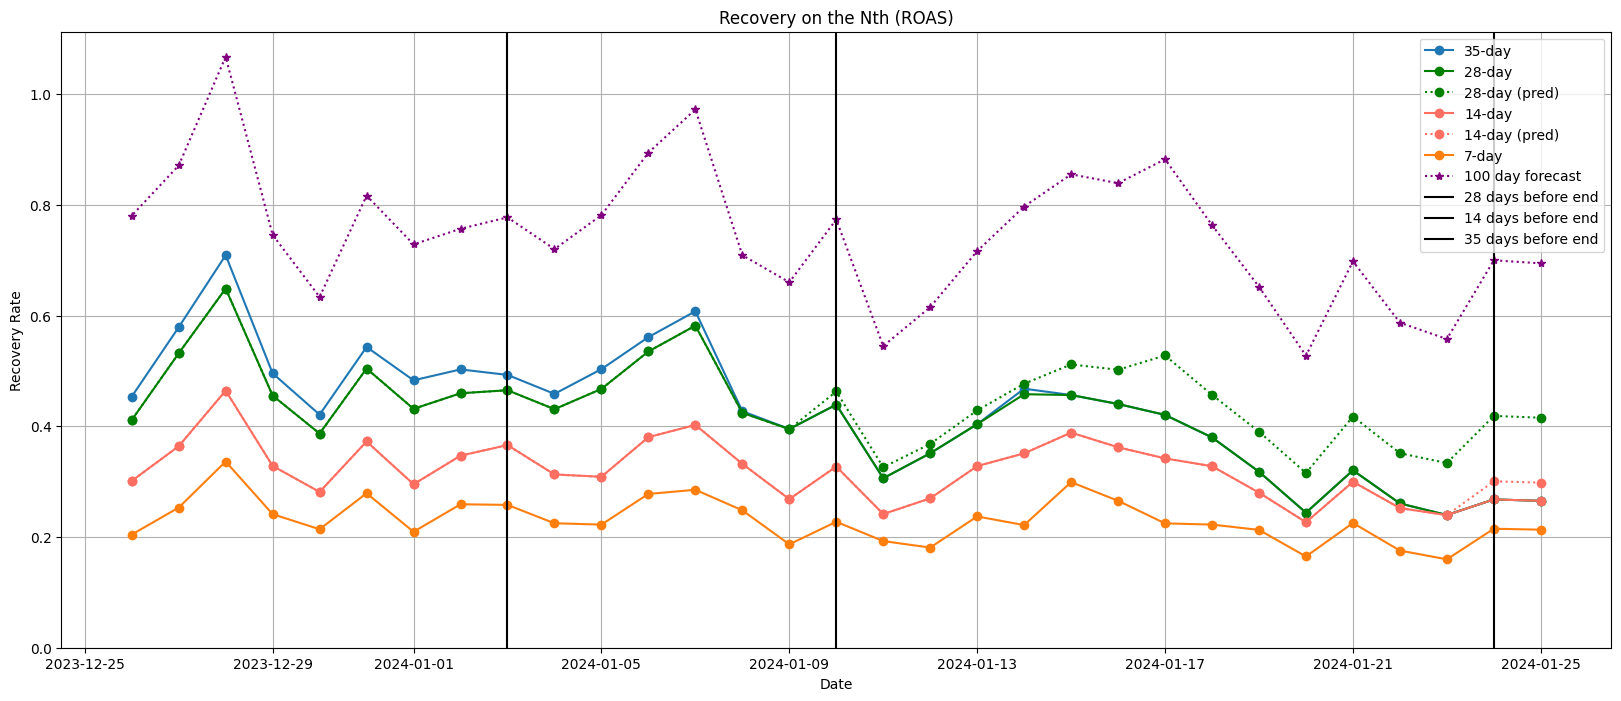

In [18]:

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import requests
from urllib.parse import urlencode
import numpy as np
from datetime import datetime as dt, timedelta
import re
import datetime

#region 1. Load BI tool information
domain = 'bingotrip-ios.inaughtycat.com'
package = 'com.trip.card.bingo.win.match.ios'
today_date = today = datetime.date.today()
start_date = today_date - pd.DateOffset(days = 95)
end_date = today_date - pd.DateOffset(days = 7)

api_details = {'bundle_id': package, 'start': start_date, 'end':  end_date}
api_url = f'http://{domain}/server/all_roi_by_user'

# Send a GET request to the API
response = requests.post(api_url, api_details)
if response.status_code == 200:
    # Request was successful
    bi_report = response.json()  # Parse the JSON response if the API returns JSON data
    bi_report = pd.DataFrame(bi_report['data'])
    print('Loaded', bi_report.shape)
else:
    print(f"Failed to retrieve data. Status code: {response.status_code}")

bi_report['date_dt'] = pd.to_datetime(bi_report['date_str'])
bi_report['date'] = bi_report['date_dt'].dt.strftime('%Y%m%d').astype(int)

#endregion

#region 2. Give me the increase dictionary 
columns_from = [7, 14, 21, 28, 35, 42, 56, 90]
response_days = [14, 21, 28, 35, 42, 56, 90]
increases_dict = pd.DataFrame(columns = ['from', 'to', 'average_percentual_increase'])

for from_k in columns_from:
    for to_k in response_days:  

        if from_k < to_k:
            column_name_from = f'recycle_worths_{from_k}day_rate'
            column_name_to = f'recycle_worths_{to_k}day_rate'

            # 1. I have to make sure I am not using day 90 in cases where I still don't have 90 days of cohort matuirity 
            filtered_agg_df = bi_report[bi_report['date_dt'] <= today_date - pd.DateOffset(days=to_k)]

            # 2. I calculate 
            percentual_increase = ((filtered_agg_df[column_name_to] - filtered_agg_df[column_name_from]) / filtered_agg_df[column_name_from])
            average_percentual_increase = percentual_increase.mean()

            increases_dict = pd.concat([increases_dict, pd.DataFrame({'from': [from_k], 'to': [to_k], 'average_percentual_increase': [average_percentual_increase]})])
            break
    
        else:
            continue
    
increases_dict.reset_index(drop = True, inplace = True)

today - timedelta(days = 35)

#endregion

#region 3. Reverstionare bi_report to bi_report_pred (With the response availability column)

relevants = [col for col in bi_report.columns if 'recycle_worths_' in col and col.endswith('day_rate') and int(col.split('_')[2][:-3]) < 120]

bi_report_pred = bi_report[bi_report['date_dt'].dt.date >= (today - timedelta(days=42))].copy(deep=True)

days_list = [7, 14, 21, 28, 35]
date = (today_date - bi_report_pred['date_dt'].dt.date)
bi_report_pred['difference'] = (date / pd.Timedelta(days = 1)).astype(int)
bi_report_pred['response_availability'] = bi_report_pred['difference'].apply(lambda x: max(day for day in days_list if day <= x))
bi_report_pred.drop(columns = ['difference'], inplace = True)
bi_report_pred.head(20)

#endregion

#region 4. Calculate the predictionas based on availability and increase dictionary 
bi_report_pred[f'day7_prediction'] = bi_report_pred[f'recycle_worths_7day_rate']

## 4.1. Part 1: For before day 90
for i in range(len(increases_dict['from'])):
    
    from_day = increases_dict['from'][i]
    to_day = increases_dict['to'][i]
    avg_percentual_increase = increases_dict['average_percentual_increase'][i]

    bi_report_pred[f'day{to_day}_prediction'] = np.where(
        bi_report_pred['response_availability'] < to_day
            , np.where(bi_report_pred[f'day{from_day}_prediction'] * (1 + avg_percentual_increase) < bi_report_pred[f'recycle_worths_{to_day}day_rate'] # if my prediction is below the actual observed
                 , bi_report_pred[f'recycle_worths_{to_day}day_rate']*1.1 # Just keep it and multiply
                 , bi_report_pred[f'day{from_day}_prediction'] * (1 + avg_percentual_increase)) # No, use the prediction
            , bi_report_pred[f'recycle_worths_{to_day}day_rate']
    )

bi_report_pred[bi_report_pred.columns[6:]]

# 4.2: For after day 90
# Calculate daily average rate from day28 to day90
daily_avg_rate = (bi_report_pred['day90_prediction'] - bi_report_pred['day28_prediction']) / 62  # 90 - 28 + 1 = 63 days, but we start from day 28

additional_days = [14, 28, 35, 42, 56, 63, 70, 77, 84, 91, 98, 100, 105, 112, 119, 120, 126, 133, 140, 147]
for day in additional_days:
    if day <= 55:
        print('过程')
    elif day <= 55:
        bi_report_pred[f'day{day}_prediction'] = bi_report_pred['day28_prediction'] + daily_avg_rate * (90 - day + 1)
    else:
        bi_report_pred[f'day{day}_prediction'] = bi_report_pred['day90_prediction'] + 0.8 * daily_avg_rate * (day - 90 + 1)
        
column_names = []
prediction_column_names = [col for col in bi_report_pred.columns if col.endswith('_prediction')]
prediction_columns = bi_report_pred.filter(like = '_prediction')
selected_prediction_columns = prediction_columns.filter(like = '_prediction').filter(regex = r'day(?:{})_prediction'.format('|'.join(map(str, additional_days))))

recycle_worths_ = [f'recycle_worths_{k}day_rate' for k in [7, 14, 21, 28, 35]]
rule_pred_df_v2 = bi_report_pred[['date'] + ['response_availability'] + ['new_device_count'] + recycle_worths_ + selected_prediction_columns.columns.tolist()]

for k in additional_days:
    k = str(k)
    old_col_name = f'day{k}_prediction'
    new_col_name = f'pred_{k}'
    if old_col_name in rule_pred_df_v2.columns:
        rule_pred_df_v2.rename(columns={old_col_name: new_col_name}, inplace=True)

rule_pred_df = rule_pred_df_v2.copy(deep = True)

#endregion

#region VI.  PAYBACK CALCULATION  ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

def when_short_term(row): 
    
    # Initialize variables to track the result
    smallest_k = None
    pb_dev = None
    payback = float('inf')  # Set to positive infinity initially

    # Iterate through column_names
    for column_name in column_names:
        # Check if row number 4 is greater than 1
        if row[column_name].values[0] > 1:
            # Extract k from the column name
            k = int(column_name.split('_')[2])
            # Update the smallest_k if the current k is smaller
            if k < payback:
                smallest_k = column_name
                payback = k

    return payback, pb_dev

pred_cols = [column_name for column_name in rule_pred_df.columns if column_name.startswith('pred_')][:-2]

def when_long_term(row): 

    pb_dev = None
    daily_increase = 0.017 # Maybe it is weekly
    remaining_spending = (1 - row['pred_126'].values[0])

    try:
        payback = round(147 + (remaining_spending / daily_increase) * 7)
    except: 
        payback = np.nan
        print('LT Problem', remaining_spending)

    return payback, pb_dev

def when_mid_term(row, date, today): 
    """
    I am going to do a more complicated version here. 
    """
    # Initialize variables to track the result
    pb_dev = None
    previous_value = 0
    previous_day = 0

    availability_limit  = int(today.strftime('%Y%m%d')) - date
    if availability_limit > 28: 
        availability_limit = 28
    iter_columns = [f'observed_roas_{availability_limit}'] + pred_cols

    # Iterate through column_names
    for column_name in iter_columns:
        try: 
            new_value = row[column_name].values[0]
            day = int(re.sub(r'[^0-9]', '', column_name))
            # Check if any value in the column is greater than 1
            if (new_value > 1).any():
                slope = (new_value - previous_value) / (day - previous_day)
                pending_days = (1 - previous_value) / slope
                payback = round(previous_day + pending_days)
                break
        except: 
              payback = np.nan
        else: 
            previous_day = day
            previous_value = new_value

    return payback, pb_dev
    
def calculate_payback(row):

    if sum((row[column_names] > 1).sum()) > 0: # the actuals are greater than 1: 
        # Just give me the one that that touches 1 (If you can take the data discrepancy into account, na jiu hao)
        payback, pb_deviation = when_short_term(row)
        
    elif sum((row[pred_cols] > 1).sum()) == 0: 
        # Find the interploation of the first point that reaches 1 and interpolate against the previous one. 
        payback, pb_deviation = when_long_term(row)

    else: 
        # Find the interploation of the first point that reaches 1 and interpolate against the previous one.  
        payback, pb_deviation = when_mid_term(row, date, today)
        pb_deviation = np.nan
        
    return payback, pb_deviation

# for source in api_df['media_source'].unique():
dates = rule_pred_df['date'].unique()

for date in dates:
        # print(source, date)
        # Input 
        row = rule_pred_df[(rule_pred_df['date'] == date)]
        # Calculation 
        payback, pb_deviation = calculate_payback(row)
        # Allocation
        rule_pred_df.loc[(rule_pred_df['date'] == date), f'payback'] = payback

rule_pred_df['payback'] = pd.to_numeric(rule_pred_df['payback'], errors='coerce').astype(pd.Int64Dtype())

columns_to_select = [col for col in rule_pred_df.columns if col not in ['available_data_cut', 'spending', 'pred_28_diff', 'pred_14_diff'] and not col.startswith('observed_')]

# rule_pred_df = rule_pred_df[columns_to_select + ['te_installs'] + ['payback']]
rule_pred_df = rule_pred_df[columns_to_select]

#endregion

#region VII. INCLUSION ERROR COLUMNS AND EXPORT OUTPUT ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

d100_error_dict = pd.read_csv('d100_error_dict_etl.csv')
labels = d100_error_dict['cohort_size'].unique().tolist()
bins = labels + [float('inf')]
rule_pred_df['cohort_size'] = pd.cut(rule_pred_df['new_device_count'], bins = bins, labels = labels, right = False)

# Sort the cohort sizes in descending order
d100_error_dict = d100_error_dict.sort_values(by='cohort_size')

# Merge based on the custom condition
new_lb = pd.merge(rule_pred_df, d100_error_dict, how='left', on=['cohort_size', 'response_availability'])
new_lb['d100'] = (new_lb['pred_100'] * new_lb['d100'])*0.03 + new_lb['d100']*0.97 # just for the looks 
new_lb['error_d100'] = new_lb.apply(lambda row: row['d100'] * ((1000 - row['new_device_count']) / 500) if row['new_device_count'] < 500 else row['d100'], axis = 1)
new_lb['pred_payback_dev'] = np.nan

calculation = new_lb['pred_payback_dev'].isnull()

new_lb.loc[calculation, 'pred_payback_dev'] = (
    round(new_lb['error_d100'] * 1.3 * new_lb['payback']) 
)

output = new_lb[['date', 'pred_14', 'pred_28', 'pred_56', 'pred_63', 'pred_70', 'pred_77',
       'pred_84', 'pred_91', 'pred_98', 'pred_100', 'pred_105', 'pred_112',
       'pred_119', 'pred_126', 'pred_133', 'pred_140', 'pred_147', 'error_d100', 'payback', 'pred_payback_dev']]

output.columns = ['date', 'pred_14', 'pred_28', 'pred_56', 'pred_63', 'pred_70', 'pred_77',
       'pred_84', 'pred_91', 'pred_98', 'pred_100', 'pred_105', 'pred_112',
       'pred_119', 'pred_126', 'pred_133', 'pred_140', 'pred_147', 'roas_d100_error', 'pred_payback', 'pb_window_error']

today = dt.now()
formatted_date = today.strftime("%Y%m%d")
output.insert(1, 'media_source', 'All')
output.to_csv('bi_report_' + str(formatted_date) + '.csv', index = False)
print(output)
#endregion





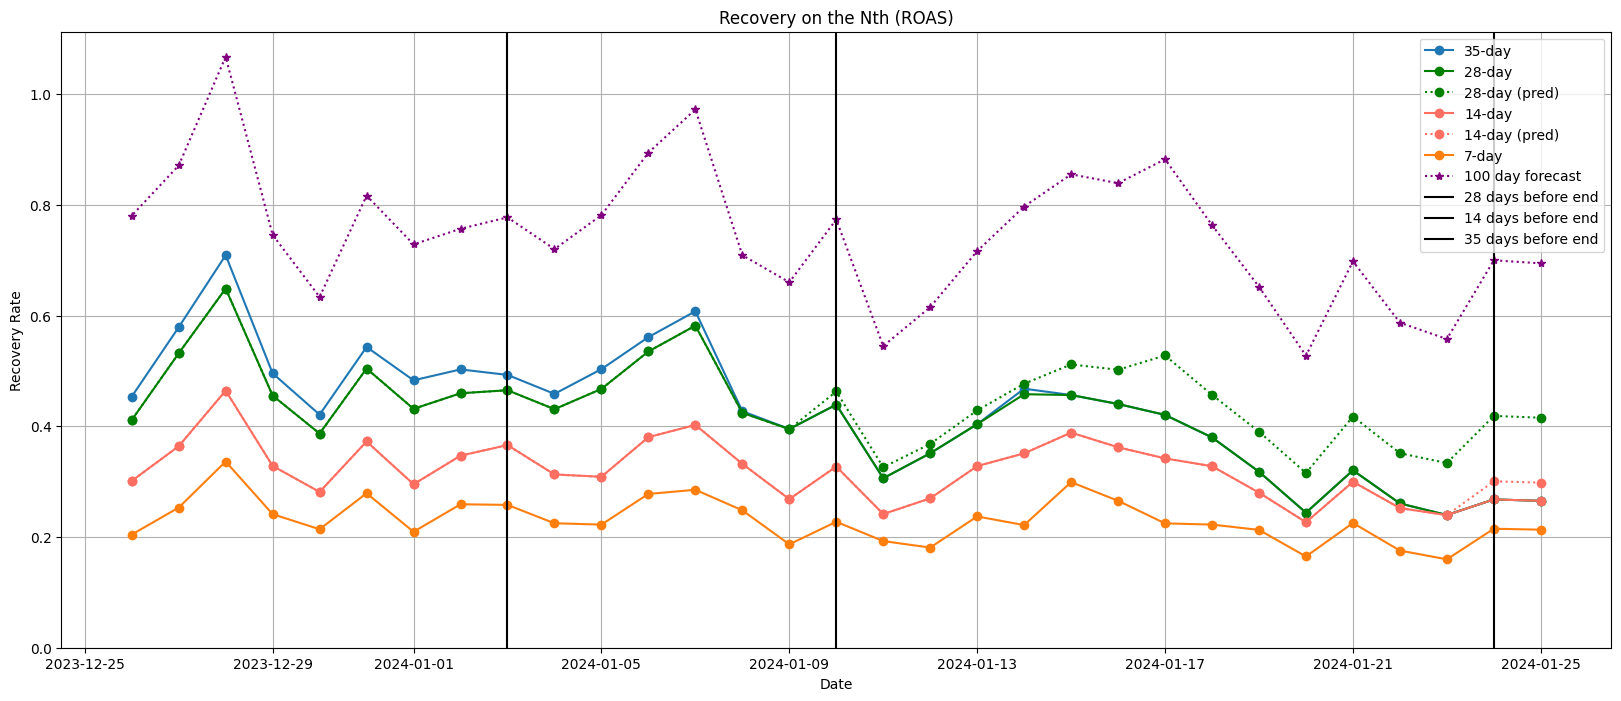

In [20]:
plt.figure(figsize=(20, 8))
from datetime import datetime
# Plotting the data
a = bi_report_pred[bi_report_pred['date_dt'] > '2023-12-01'][bi_report_pred['date_dt'] <= '2024-01-25']
plt.plot(a['date_dt'], a['recycle_worths_35day_rate'], marker='o', label='35-day')
plt.plot(a['date_dt'], a['recycle_worths_28day_rate'], marker='o', label='28-day', color = 'green')
plt.plot(a['date_dt'], a['day28_prediction'], marker='o', label='28-day (pred)', linestyle='dotted', color = 'green')
plt.plot(a['date_dt'], a['recycle_worths_14day_rate'], marker='o', label='14-day', color = '#FF6F61')
plt.plot(a['date_dt'], a['day14_prediction'], marker='o', label='14-day (pred)', linestyle='dotted', color='#FF6F61')  # Coralle Orange
plt.plot(a['date_dt'], a['recycle_worths_7day_rate'], marker='o', label='7-day')

# Plotting the 100-day forecast with a solid line
plt.plot(a['date_dt'], a['day100_prediction'], marker='*', label='100 day forecast', color = '#800080', linestyle='dotted')

# Set y-axis limit to start from 0
plt.ylim(bottom=0)

# Add vertical lines with solid black color
current_date = datetime.now().date()
target_date = current_date - timedelta(days=27)
plt.axvline(target_date, color='black', linestyle='-', label='28 days before end')

current_date = datetime.now().date()
target_date = current_date - timedelta(days=13)
plt.axvline(target_date, color='black', linestyle='-', label='14 days before end')

current_date = datetime.now().date()
target_date = current_date - timedelta(days=34)
plt.axvline(target_date, color='black', linestyle='-', label='35 days before end')

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Recovery Rate')
plt.title('Recovery on the Nth (ROAS)')
plt.legend()

plt.grid(True)
plt.show()